# Funções

In [1]:
import os
import time
import copy
import torch
import torchvision
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.encoders import get_preprocessing_fn
import matplotlib.pyplot as plt

import numpy as np
from PIL import Image

from sklearn.metrics import jaccard_score
from medpy.metric.binary import hd, asd 

import ssl

/home/tivo/TI0160-VisaoComputacionalAplicadaASaude-UFC-2024.1/env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
torch.cuda.empty_cache()

In [3]:
ssl._create_default_https_context = ssl._create_unverified_context

PATCH_SIZE = (256, 256)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BATCH_SIZE = 16
N_EPOCHS = 25
N_WORKERS = 10
MODELS_PATH = "models/segmentation"

In [4]:
class DatasetBreastCancer(Dataset):
    def __init__(self, image_paths, mask_paths):
        """
        image_paths: Lista de caminhos das imagens.
        mask_paths: Lista de caminhos das máscaras correspondentes.
        """
        self.transform = torchvision.transforms.Compose(
            [
                torchvision.transforms.Resize(PATCH_SIZE),
                torchvision.transforms.ToTensor(),
            ]
        )
        self.image_paths = image_paths
        self.mask_paths = mask_paths


    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        mask_path = self.mask_paths[idx]

        # Carrega a imagem e a máscara
        image = Image.open(img_path).convert('L')
        mask = Image.open(mask_path).convert('L')

        image = self.transform(image)
        mask = self.transform(mask)

        return image, mask

In [5]:
import os
from sklearn.model_selection import train_test_split

base_dir = '../DATA/raw'
categories = ['benign', 'malignant']

train_image_paths = []
val_image_paths = []
test_image_paths = []
train_mask_paths = []
val_mask_paths = []
test_mask_paths = []

for category in categories:
    category_dir = os.path.join(base_dir, category)
    category_image_paths = []
    category_mask_paths = []
    
    image_fnames = sorted([fname for fname in os.listdir(category_dir) if not fname.endswith('_mask.png')])
    mask_fnames = [fname for fname in os.listdir(category_dir) if fname.endswith('_mask.png')]
    
    for fname in image_fnames:
        category_image_paths.append(os.path.join(category_dir, fname))
        category_mask_paths.append(os.path.join(category_dir, fname.replace('.png', '_mask.png')))
    
    for fname in mask_fnames:
        if os.path.join(category_dir, fname) not in category_mask_paths:
            category_mask_paths.append(os.path.join(category_dir, fname))
    
    # Dividir os caminhos em conjuntos de treino e validação para cada categoria
    train_img, temp_image_paths, train_mask, temp_mask_paths = train_test_split(
        category_image_paths, category_mask_paths, test_size=0.3, random_state=42
    )
    val_img, test_img, val_mask, test_mask = train_test_split(
        temp_image_paths, temp_mask_paths, test_size=0.5, random_state=42
    )
    
    train_image_paths.extend(train_img)
    val_image_paths.extend(val_img)
    test_image_paths.extend(test_img)
    train_mask_paths.extend(train_mask)
    val_mask_paths.extend(val_mask)
    test_mask_paths.extend(test_mask)

In [6]:
train_dataset = DatasetBreastCancer(train_image_paths, train_mask_paths)
val_dataset = DatasetBreastCancer(val_image_paths, val_mask_paths)
test_dataset = DatasetBreastCancer(test_image_paths, test_mask_paths)

In [7]:
def train(model, train_loader, val_loader, loss_fn, optimizer, n_epochs, patience=10):
    best_loss = float('inf')
    best_model_wts = copy.deepcopy(model.state_dict())
    epochs_no_improve = 0

    train_losses = []
    val_losses = []

    for epoch in range(n_epochs):
        running_loss = 0.0
        val_loss = 0.0

        # Treinamento
        model.train()
        for images, masks in train_loader:
            images = images.to(DEVICE)
            masks = masks.to(DEVICE)  # Removido .unsqueeze(1)

            optimizer.zero_grad()
            outputs = model(images)
            
            loss = loss_fn(outputs, masks)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        # Validação
        model.eval()
        with torch.no_grad():
            for images, masks in val_loader:
                images = images.to(DEVICE)
                masks = masks.to(DEVICE)  # Removido .unsqueeze(1)

                outputs = model(images)
                loss = loss_fn(outputs, masks)
                val_loss += loss.item()

        epoch_loss = running_loss / len(train_loader)
        epoch_val_loss = val_loss / len(val_loader)

        train_losses.append(epoch_loss)
        val_losses.append(epoch_val_loss)

        print(f'Época {epoch+1}/{n_epochs} / Loss: {epoch_loss:.4f} / Val Loss: {epoch_val_loss:.4f}')

        # Verificar melhora no loss de validação
        if epoch_val_loss < best_loss:
            best_loss = epoch_val_loss
            best_model_wts = copy.deepcopy(model.state_dict())
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print(f'Early stopping após {epoch+1} épocas.')
                break

    # Plotar Loss e Val Loss
    epochs_range = range(1, len(train_losses)+1)
    plt.plot(epochs_range, train_losses, label='Loss de Treinamento')
    plt.plot(epochs_range, val_losses, label='Loss de Validação')
    plt.xlabel('Épocas')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

In [8]:
import torch
from scipy.spatial.distance import directed_hausdorff


def balanced_average_hausdorff_distance(predictions: torch.Tensor, targets: torch.Tensor) -> torch.Tensor:
    """
    Calculates the balanced average Hausdorff distance between predictions and targets.

    Parameters:
        predictions (torch.Tensor):
            The predicted tensor.
        targets (torch.Tensor):
            The target tensor.

    Returns:
        torch.Tensor:
            The balanced average Hausdorff distance.
    """

    batch_size, channels, *_ = targets.shape
    values = torch.zeros((batch_size, channels))

    for batch in range(batch_size):
        for channel in range(channels):
            targets_, predictions_ = (
                targets[batch][channel].detach().cpu(),
                predictions[batch][channel].detach().cpu(),
            )
            values[batch, channel] = (
                directed_hausdorff(targets_, predictions_)[0]
                + directed_hausdorff(predictions_, targets_)[0]
                * predictions_.view(1, -1).size(1)
                / targets_.view(1, -1).size(1)
            ) / 2

    return values.mean()

In [9]:
import torch
from medpy.metric.binary import asd
import numpy as np


def handle_empty_array(array: np.ndarray) -> np.ndarray:
    """
    Handle empty arrays by filling them with a default value if they contain only zeros.

    Args:
        array (np.ndarray):
            Input array.

    Returns:
        np.ndarray:
            Array with zeros replaced by a default value if the array was empty.
    """

    if np.count_nonzero(array) == 0:
        array[0, 0] = 1

    return array


def average_surface_distance(
    predictions: torch.Tensor, targets: torch.Tensor, threshold: float = 0.5, connectivity: int = 1
) -> torch.Tensor:
    """
    Calculates the average surface distance between two binary segmentation masks.

    Parameters:
        predictions (torch.Tensor):
            The first binary segmentation mask tensor.
        targets (torch.Tensor):
            The second binary segmentation mask tensor.
        threshold (float, optional):
            Threshold value to convert predictions to binary. Defaults to 0.5.

    Returns:
        torch.Tensor:
            The average surface distance.
    """

    predictions_, targets_ = (predictions > threshold).detach().cpu().numpy(), targets.detach().cpu().numpy()

    predictions_, targets_ = handle_empty_array(predictions_), handle_empty_array(targets_)

    return asd(predictions_, targets_)

In [10]:
import torch


def jaccard_index(predictions: torch.Tensor, targets: torch.Tensor, threshold: float = 0.5) -> torch.Tensor:
    """
    Calculates the Jaccard Index metric for a batch of predictions.

    Parameters:
        predictions (torch.Tensor):
            The predicted tensor.
        targets (torch.Tensor):
            The target tensor.
        threshold (float):
            The threshold above which predictions are considered positive. Defaults to 0.5.

    Returns:
        torch.Tensor:
            The Jaccard Index value.
    """

    predictions_, targets_ = predictions.view(predictions.size(0), -1), targets.view(targets.size(0), -1)

    y_pred_positive = torch.round((predictions_ > threshold).int())
    y_pred_negative = 1 - y_pred_positive

    y_positive = torch.round(torch.clip(targets_, 0, 1))
    y_negative = 1 - y_positive

    TP = (y_positive * y_pred_positive).sum(dim=1)
    _ = (y_negative * y_pred_negative).sum(dim=1)

    FP = (y_negative * y_pred_positive).sum(dim=1)
    FN = (y_positive * y_pred_negative).sum(dim=1)

    return ((TP) / (TP + FP + FN)).mean()

In [11]:
import torch


def dice(predictions: torch.Tensor, targets: torch.Tensor, threshold: float = 0.5) -> torch.Tensor:
    """
    Calculates the Dice score metric for a batch of predictions.

    Parameters:
        predictions (torch.Tensor):
            The predicted tensor.
        targets (torch.Tensor):
            The target tensor.
        threshold (float):
            The threshold above which predictions are considered positive. Defaults to 0.5.

    Returns:
        torch.Tensor:
            The Dice score value.
    """

    predictions_, targets_ = predictions.view(predictions.size(0), -1), targets.view(targets.size(0), -1)

    y_pred_positive = torch.round((predictions_ > threshold).int())
    y_pred_negative = 1 - y_pred_positive

    y_positive = torch.round(torch.clip(targets_, 0, 1))
    y_negative = 1 - y_positive

    TP = (y_positive * y_pred_positive).sum(dim=1)
    _ = (y_negative * y_pred_negative).sum(dim=1)

    FP = (y_negative * y_pred_positive).sum(dim=1)
    FN = (y_positive * y_pred_negative).sum(dim=1)

    return ((2 * TP) / (2 * TP + FP + FN)).mean()

In [12]:
def evaluate(model, loader):
    """
    Avalia o modelo utilizando as funções de métrica disponíveis.

    Parâmetros:
        model (torch.nn.Module): O modelo treinado a ser avaliado.
        loader (torch.utils.data.DataLoader): DataLoader para o conjunto de dados de avaliação.

    Retorna:
        dict: Um dicionário contendo as médias das métricas avaliadas.
    """
    model.eval()
    dice_scores = []
    jaccard_scores = []
    hausdorff_distances = []
    avg_surface_distances = []
    times = []

    with torch.no_grad():
        for images, masks in loader:
            images = images.to(DEVICE)
            masks = masks.to(DEVICE)

            start_time = time.time()
            outputs = model(images)
            end_time = time.time()

            preds = torch.sigmoid(outputs)

            for i in range(images.size(0)):
                pred = preds[i].cpu()
                mask = masks[i].cpu()

                # Utiliza as funções de métrica definidas anteriormente
                dice_coefficient = dice(pred, mask)
                dice_scores.append(dice_coefficient)

                jaccard = jaccard_index(pred, mask)
                jaccard_scores.append(jaccard)

                hausdorff = balanced_average_hausdorff_distance(pred.unsqueeze(0), mask.unsqueeze(0))
                hausdorff_distances.append(hausdorff.item())

                avg_surf_dist = average_surface_distance(pred.unsqueeze(0).float(), mask.unsqueeze(0).float())
                avg_surface_distances.append(avg_surf_dist.item())

            times.append(end_time - start_time)

    # Calcula a média das métricas
    avg_dice = np.mean(dice_scores)
    avg_jaccard = np.mean(jaccard_scores)
    avg_hausdorff = np.mean(hausdorff_distances)
    avg_asd = np.mean(avg_surface_distances)
    total_time = np.mean(times)
    
    return {
        "Mean Dice Coefficient": avg_dice,
        "Mean Jaccard Index": avg_jaccard,
        "Mean Hausdorff Distance": avg_hausdorff,
        "Mean Average Surface Distance": avg_asd,
        "Processing Time (s)": total_time
    }

In [13]:
def save_model(model, path):
    torch.save(model.state_dict(), path)

# Encoder: Densenet201 / Decoder: UNET

Treinando modelo com DiceLoss...
Época 1/25 / Loss: 0.7355 / Val Loss: 0.7802
Época 2/25 / Loss: 0.6152 / Val Loss: 0.7254
Época 3/25 / Loss: 0.5384 / Val Loss: 0.6765
Época 4/25 / Loss: 0.4872 / Val Loss: 0.6330
Época 5/25 / Loss: 0.4414 / Val Loss: 0.6212
Época 6/25 / Loss: 0.3910 / Val Loss: 0.6116
Época 7/25 / Loss: 0.3584 / Val Loss: 0.5839
Época 8/25 / Loss: 0.3417 / Val Loss: 0.5875
Época 9/25 / Loss: 0.3064 / Val Loss: 0.5505
Época 10/25 / Loss: 0.2640 / Val Loss: 0.5211
Época 11/25 / Loss: 0.2398 / Val Loss: 0.5121
Época 12/25 / Loss: 0.2139 / Val Loss: 0.4809
Época 13/25 / Loss: 0.1966 / Val Loss: 0.4800
Época 14/25 / Loss: 0.1789 / Val Loss: 0.4671
Época 15/25 / Loss: 0.1641 / Val Loss: 0.4722
Época 16/25 / Loss: 0.1497 / Val Loss: 0.4616
Época 17/25 / Loss: 0.1352 / Val Loss: 0.4343
Época 18/25 / Loss: 0.1214 / Val Loss: 0.4330
Época 19/25 / Loss: 0.1176 / Val Loss: 0.4273
Época 20/25 / Loss: 0.1073 / Val Loss: 0.4081
Época 21/25 / Loss: 0.1086 / Val Loss: 0.4293
Época 22/2

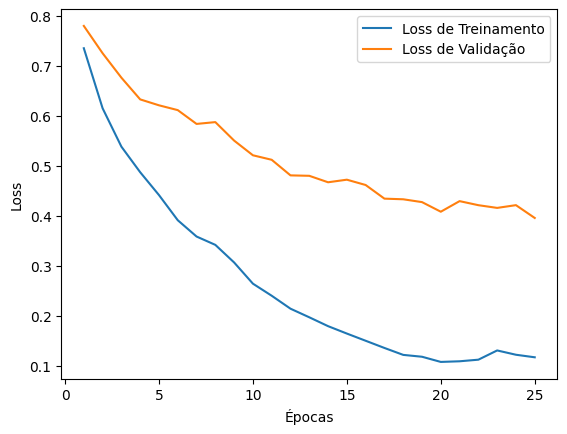

Modelo treinado!

Métricas de avaliação para DiceLoss:
	Mean Dice Coefficient: 0.7547
	Mean Jaccard Index: 0.6557
	Mean Hausdorff Distance: 4.4136
	Mean Average Surface Distance: 10.2292
	Processing Time (s): 0.0688
Treinando modelo com FocalLoss...
Época 1/25 / Loss: 0.1195 / Val Loss: 0.0901
Época 2/25 / Loss: 0.0563 / Val Loss: 0.0683
Época 3/25 / Loss: 0.0361 / Val Loss: 0.0624
Época 4/25 / Loss: 0.0274 / Val Loss: 0.0517
Época 5/25 / Loss: 0.0245 / Val Loss: 0.0512
Época 6/25 / Loss: 0.0194 / Val Loss: 0.0552
Época 7/25 / Loss: 0.0158 / Val Loss: 0.0555
Época 8/25 / Loss: 0.0141 / Val Loss: 0.0551
Época 9/25 / Loss: 0.0142 / Val Loss: 0.0580
Época 10/25 / Loss: 0.0137 / Val Loss: 0.0541
Época 11/25 / Loss: 0.0121 / Val Loss: 0.0547
Época 12/25 / Loss: 0.0106 / Val Loss: 0.0575
Época 13/25 / Loss: 0.0098 / Val Loss: 0.0588
Época 14/25 / Loss: 0.0116 / Val Loss: 0.0623
Época 15/25 / Loss: 0.0158 / Val Loss: 0.0551
Early stopping após 15 épocas.


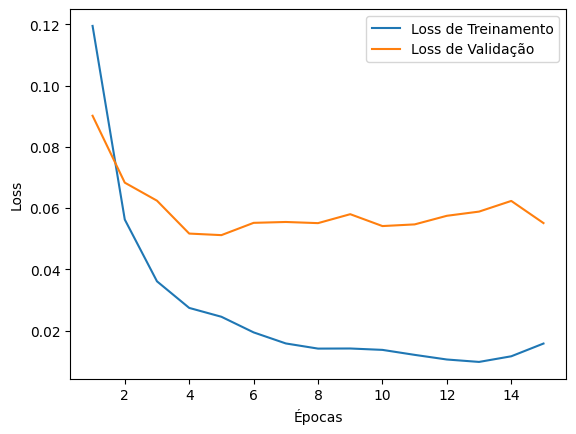

Modelo treinado!

Métricas de avaliação para FocalLoss:
	Mean Dice Coefficient: 0.7012
	Mean Jaccard Index: 0.5954
	Mean Hausdorff Distance: 4.5687
	Mean Average Surface Distance: 6.2753
	Processing Time (s): 0.0485
Treinando modelo com LovaszLoss...
Época 1/25 / Loss: 1.3502 / Val Loss: 1.1950
Época 2/25 / Loss: 1.0368 / Val Loss: 1.0345
Época 3/25 / Loss: 1.0023 / Val Loss: 1.0368
Época 4/25 / Loss: 0.9822 / Val Loss: 1.0514
Época 5/25 / Loss: 0.9263 / Val Loss: 1.1117
Época 6/25 / Loss: 0.8695 / Val Loss: 1.0990
Época 7/25 / Loss: 0.7338 / Val Loss: 1.1824
Época 8/25 / Loss: 0.5768 / Val Loss: 1.1583
Época 9/25 / Loss: 0.5206 / Val Loss: 1.0655
Época 10/25 / Loss: 0.4721 / Val Loss: 1.0488
Época 11/25 / Loss: 0.4548 / Val Loss: 1.1576
Época 12/25 / Loss: 0.3832 / Val Loss: 1.1293
Early stopping após 12 épocas.


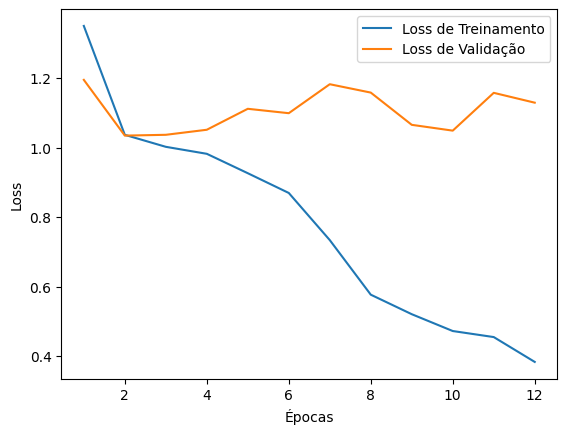

Modelo treinado!

Métricas de avaliação para LovaszLoss:
	Mean Dice Coefficient: 0.7062
	Mean Jaccard Index: 0.6064
	Mean Hausdorff Distance: 5.0440
	Mean Average Surface Distance: 9.0085
	Processing Time (s): 0.0532


In [14]:
preprocess_input = get_preprocessing_fn('densenet201', pretrained='imagenet')

# Definição das funções de perda
loss_functions = {
    "DiceLoss": smp.losses.DiceLoss(smp.losses.BINARY_MODE),
    "FocalLoss": smp.losses.FocalLoss(mode=smp.losses.BINARY_MODE),
    "LovaszLoss": smp.losses.LovaszLoss(smp.losses.BINARY_MODE)
}

for loss_name, loss_fn in loss_functions.items():
    print(f"Treinando modelo com {loss_name}...")
    
    # Inicializa o modelo
    model = smp.Unet(
        encoder_name="densenet201",
        encoder_weights="imagenet",
        in_channels=1,
        classes=1,
    ).to(DEVICE)
    
    # Inicializa o otimizador
    optimizer = optim.Adam(model.parameters(), lr=1e-4)
    
    # Define o caminho para salvar o modelo
    model_path = os.path.join(MODELS_PATH, f"densenet201_unet_{loss_name.lower()}_model.pth")
    
    if os.path.exists(model_path):
        model.load_state_dict(torch.load(model_path))
        print("Modelo carregado!")
    else:
        # Define os data loaders
        train_loader = DataLoader(
            train_dataset,
            batch_size=BATCH_SIZE,
            pin_memory=True,
            shuffle=True,
            drop_last=False,
            num_workers=N_WORKERS
        )
    
        val_loader = DataLoader(
            val_dataset,
            batch_size=BATCH_SIZE,
            pin_memory=True,
            shuffle=False,
            drop_last=False,
            num_workers=N_WORKERS
        )
        
        # Treina o modelo
        train(model, train_loader, val_loader, loss_fn, optimizer, 25)
        
        # Salva o modelo treinado
        save_model(model, model_path)
        print("Modelo treinado!")
    
    # Carrega o data loader de teste
    test_loader = DataLoader(
        test_dataset,
        batch_size=BATCH_SIZE,
        pin_memory=True,
        shuffle=False,
        drop_last=False,
        num_workers=N_WORKERS
    )
    
    # Avalia o modelo
    metrics = evaluate(model, test_loader)
    print(f"\nMétricas de avaliação para {loss_name}:")
    for metric, value in metrics.items():
        print(f"\t{metric}: {value:.4f}")


# Encoder: Resnet152 / Decoder: UNET

Treinando modelo com DiceLoss...
Época 1/25 / Loss: 0.7422 / Val Loss: 0.7929
Época 2/25 / Loss: 0.6269 / Val Loss: 0.7446
Época 3/25 / Loss: 0.5728 / Val Loss: 0.7137
Época 4/25 / Loss: 0.5299 / Val Loss: 0.6719
Época 5/25 / Loss: 0.4754 / Val Loss: 0.6603
Época 6/25 / Loss: 0.4222 / Val Loss: 0.6287
Época 7/25 / Loss: 0.3922 / Val Loss: 0.6152
Época 8/25 / Loss: 0.3550 / Val Loss: 0.5704
Época 9/25 / Loss: 0.3216 / Val Loss: 0.5274
Época 10/25 / Loss: 0.2838 / Val Loss: 0.5439
Época 11/25 / Loss: 0.2677 / Val Loss: 0.5301
Época 12/25 / Loss: 0.2421 / Val Loss: 0.5124
Época 13/25 / Loss: 0.2095 / Val Loss: 0.5047
Época 14/25 / Loss: 0.1946 / Val Loss: 0.4863
Época 15/25 / Loss: 0.1996 / Val Loss: 0.4770
Época 16/25 / Loss: 0.1842 / Val Loss: 0.4908
Época 17/25 / Loss: 0.1596 / Val Loss: 0.4607
Época 18/25 / Loss: 0.1354 / Val Loss: 0.4346
Época 19/25 / Loss: 0.1291 / Val Loss: 0.4329
Época 20/25 / Loss: 0.1160 / Val Loss: 0.4274
Época 21/25 / Loss: 0.1144 / Val Loss: 0.4443
Época 22/2

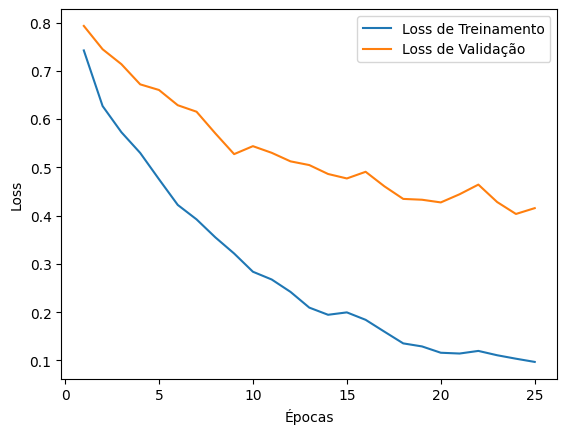

Modelo treinado!

Métricas de avaliação para DiceLoss:
	Mean Dice Coefficient: 0.7685
	Mean Jaccard Index: 0.6802
	Mean Hausdorff Distance: 3.9759
	Mean Average Surface Distance: 7.5639
	Processing Time (s): 0.0353
Treinando modelo com FocalLoss...
Época 1/25 / Loss: 0.0916 / Val Loss: 0.0810
Época 2/25 / Loss: 0.0432 / Val Loss: 0.0591
Época 3/25 / Loss: 0.0273 / Val Loss: 0.0431
Época 4/25 / Loss: 0.0230 / Val Loss: 0.0491
Época 5/25 / Loss: 0.0223 / Val Loss: 0.0576
Época 6/25 / Loss: 0.0200 / Val Loss: 0.0479
Época 7/25 / Loss: 0.0158 / Val Loss: 0.0499
Época 8/25 / Loss: 0.0134 / Val Loss: 0.0528
Época 9/25 / Loss: 0.0119 / Val Loss: 0.0554
Época 10/25 / Loss: 0.0115 / Val Loss: 0.0499
Época 11/25 / Loss: 0.0116 / Val Loss: 0.0574
Época 12/25 / Loss: 0.0097 / Val Loss: 0.0552
Época 13/25 / Loss: 0.0090 / Val Loss: 0.0561
Early stopping após 13 épocas.


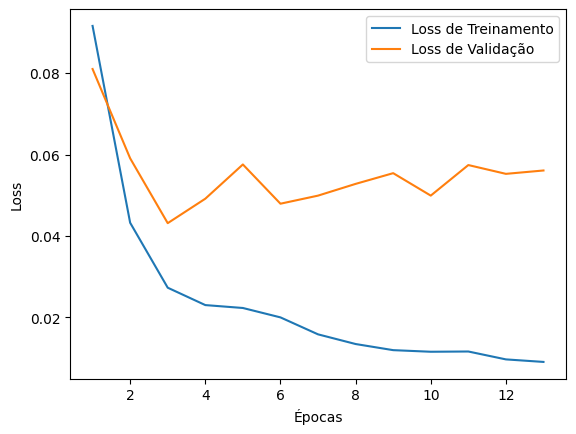

Modelo treinado!

Métricas de avaliação para FocalLoss:
	Mean Dice Coefficient: 0.7354
	Mean Jaccard Index: 0.6342
	Mean Hausdorff Distance: 4.2467
	Mean Average Surface Distance: 7.3753
	Processing Time (s): 0.0302
Treinando modelo com LovaszLoss...
Época 1/25 / Loss: 1.2879 / Val Loss: 1.2348
Época 2/25 / Loss: 0.9700 / Val Loss: 1.1016
Época 3/25 / Loss: 0.7916 / Val Loss: 1.2250
Época 4/25 / Loss: 0.6680 / Val Loss: 1.3488
Época 5/25 / Loss: 0.6049 / Val Loss: 1.1756
Época 6/25 / Loss: 0.5131 / Val Loss: 1.1738
Época 7/25 / Loss: 0.4534 / Val Loss: 1.2663
Época 8/25 / Loss: 0.3823 / Val Loss: 1.1201
Época 9/25 / Loss: 0.3837 / Val Loss: 1.1516
Época 10/25 / Loss: 0.3611 / Val Loss: 1.0813
Época 11/25 / Loss: 0.3197 / Val Loss: 1.1295
Época 12/25 / Loss: 0.2752 / Val Loss: 1.1421
Época 13/25 / Loss: 0.2557 / Val Loss: 1.0919
Época 14/25 / Loss: 0.2243 / Val Loss: 1.1018
Época 15/25 / Loss: 0.2030 / Val Loss: 1.1635
Época 16/25 / Loss: 0.2056 / Val Loss: 1.2662
Época 17/25 / Loss: 0.

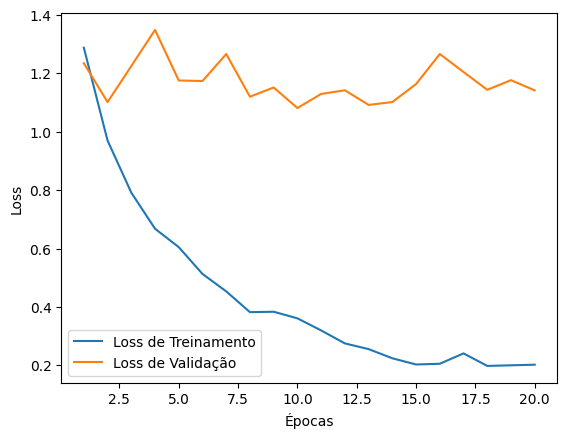

Modelo treinado!

Métricas de avaliação para LovaszLoss:
	Mean Dice Coefficient: 0.7327
	Mean Jaccard Index: 0.6482
	Mean Hausdorff Distance: 4.7590
	Mean Average Surface Distance: 7.3731
	Processing Time (s): 0.0346


In [15]:
preprocess_input = get_preprocessing_fn('resnet152', pretrained='imagenet')

# Definição das funções de perda
loss_functions = {
    "DiceLoss": smp.losses.DiceLoss(smp.losses.BINARY_MODE),
    "FocalLoss": smp.losses.FocalLoss(mode=smp.losses.BINARY_MODE),
    "LovaszLoss": smp.losses.LovaszLoss(smp.losses.BINARY_MODE)
}

for loss_name, loss_fn in loss_functions.items():
    print(f"Treinando modelo com {loss_name}...")
    
    # Inicializa o modelo
    model = smp.Unet(
        encoder_name="resnet152",
        encoder_weights="imagenet",
        in_channels=1,
        classes=1,
    ).to(DEVICE)
    
    # Inicializa o otimizador
    optimizer = optim.Adam(model.parameters(), lr=1e-4)
    
    # Define o caminho para salvar o modelo
    model_path = os.path.join(MODELS_PATH, f"resnet152_unet_{loss_name.lower()}_model.pth")
    
    if os.path.exists(model_path):
        model.load_state_dict(torch.load(model_path))
        print("Modelo carregado!")
    else:
        # Define os data loaders
        train_loader = DataLoader(
            train_dataset,
            batch_size=BATCH_SIZE,
            pin_memory=True,
            shuffle=True,
            drop_last=False,
            num_workers=N_WORKERS
        )
    
        val_loader = DataLoader(
            val_dataset,
            batch_size=BATCH_SIZE,
            pin_memory=True,
            shuffle=False,
            drop_last=False,
            num_workers=N_WORKERS
        )
        
        # Treina o modelo
        train(model, train_loader, val_loader, loss_fn, optimizer, 25)
        
        # Salva o modelo treinado
        save_model(model, model_path)
        print("Modelo treinado!")
    
    # Carrega o data loader de teste
    test_loader = DataLoader(
        test_dataset,
        batch_size=BATCH_SIZE,
        pin_memory=True,
        shuffle=False,
        drop_last=False,
        num_workers=N_WORKERS
    )
    
    # Avalia o modelo
    metrics = evaluate(model, test_loader)
    print(f"\nMétricas de avaliação para {loss_name}:")
    for metric, value in metrics.items():
        print(f"\t{metric}: {value:.4f}")


# Encoder: MobileNetV2 / Decoder: UNET


Treinando modelo com DiceLoss...
Época 1/25 / Loss: 0.7597 / Val Loss: 0.7821
Época 2/25 / Loss: 0.6489 / Val Loss: 0.7474
Época 3/25 / Loss: 0.5828 / Val Loss: 0.7178
Época 4/25 / Loss: 0.5143 / Val Loss: 0.6920
Época 5/25 / Loss: 0.4867 / Val Loss: 0.6441
Época 6/25 / Loss: 0.4288 / Val Loss: 0.6446
Época 7/25 / Loss: 0.4011 / Val Loss: 0.6029
Época 8/25 / Loss: 0.3611 / Val Loss: 0.5974
Época 9/25 / Loss: 0.3230 / Val Loss: 0.5810
Época 10/25 / Loss: 0.2907 / Val Loss: 0.5543
Época 11/25 / Loss: 0.2693 / Val Loss: 0.5347
Época 12/25 / Loss: 0.2469 / Val Loss: 0.5308
Época 13/25 / Loss: 0.2220 / Val Loss: 0.5065
Época 14/25 / Loss: 0.2040 / Val Loss: 0.5218
Época 15/25 / Loss: 0.1842 / Val Loss: 0.4925
Época 16/25 / Loss: 0.1758 / Val Loss: 0.4917
Época 17/25 / Loss: 0.1587 / Val Loss: 0.4725
Época 18/25 / Loss: 0.1491 / Val Loss: 0.4752
Época 19/25 / Loss: 0.1392 / Val Loss: 0.4648
Época 20/25 / Loss: 0.1298 / Val Loss: 0.4532
Época 21/25 / Loss: 0.1208 / Val Loss: 0.4679
Época 22/2

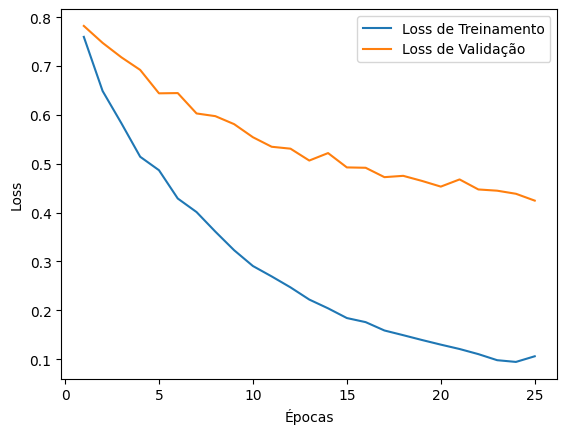

Modelo treinado!

Métricas de avaliação para DiceLoss:
	Mean Dice Coefficient: 0.7120
	Mean Jaccard Index: 0.6157
	Mean Hausdorff Distance: 4.2498
	Mean Average Surface Distance: 12.7139
	Processing Time (s): 0.0168
Treinando modelo com FocalLoss...
Época 1/25 / Loss: 0.1161 / Val Loss: 0.1501
Época 2/25 / Loss: 0.0624 / Val Loss: 0.1032
Época 3/25 / Loss: 0.0412 / Val Loss: 0.0682
Época 4/25 / Loss: 0.0296 / Val Loss: 0.0520
Época 5/25 / Loss: 0.0245 / Val Loss: 0.0542
Época 6/25 / Loss: 0.0228 / Val Loss: 0.0556
Época 7/25 / Loss: 0.0199 / Val Loss: 0.0564
Época 8/25 / Loss: 0.0192 / Val Loss: 0.0547
Época 9/25 / Loss: 0.0187 / Val Loss: 0.0549
Época 10/25 / Loss: 0.0149 / Val Loss: 0.0513
Época 11/25 / Loss: 0.0137 / Val Loss: 0.0561
Época 12/25 / Loss: 0.0126 / Val Loss: 0.0566
Época 13/25 / Loss: 0.0119 / Val Loss: 0.0616
Época 14/25 / Loss: 0.0111 / Val Loss: 0.0613
Época 15/25 / Loss: 0.0102 / Val Loss: 0.0603
Época 16/25 / Loss: 0.0107 / Val Loss: 0.0655
Época 17/25 / Loss: 0.0

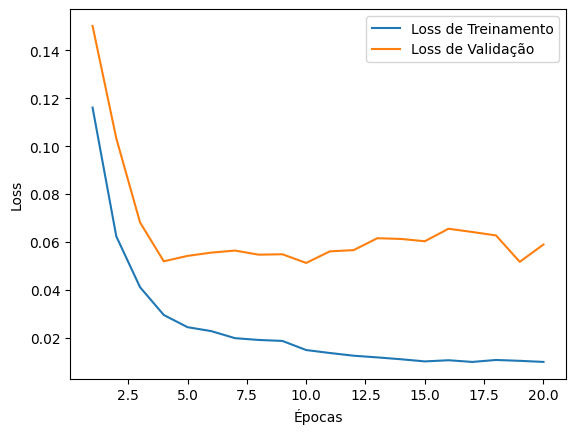

Modelo treinado!

Métricas de avaliação para FocalLoss:
	Mean Dice Coefficient: 0.7198
	Mean Jaccard Index: 0.6208
	Mean Hausdorff Distance: 4.3201
	Mean Average Surface Distance: 6.2559
	Processing Time (s): 0.0144
Treinando modelo com LovaszLoss...
Época 1/25 / Loss: 1.3467 / Val Loss: 2.0158
Época 2/25 / Loss: 1.0292 / Val Loss: 1.0990
Época 3/25 / Loss: 0.9610 / Val Loss: 1.1139
Época 4/25 / Loss: 0.8679 / Val Loss: 1.1417
Época 5/25 / Loss: 0.7780 / Val Loss: 1.1858
Época 6/25 / Loss: 0.6378 / Val Loss: 1.1771
Época 7/25 / Loss: 0.5796 / Val Loss: 1.2397
Época 8/25 / Loss: 0.5207 / Val Loss: 1.1818
Época 9/25 / Loss: 0.4939 / Val Loss: 1.2300
Época 10/25 / Loss: 0.4391 / Val Loss: 1.1866
Época 11/25 / Loss: 0.3968 / Val Loss: 1.2072
Época 12/25 / Loss: 0.3627 / Val Loss: 1.1865
Early stopping após 12 épocas.


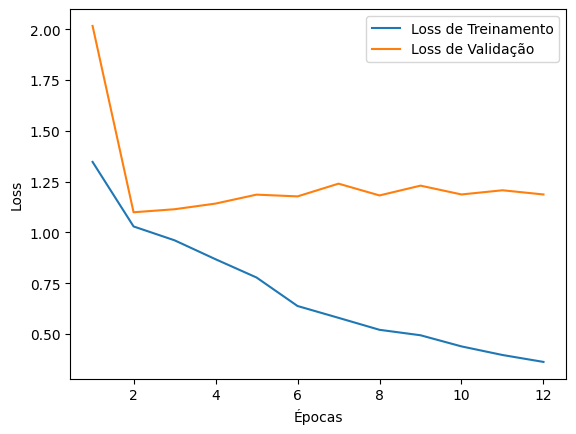

Modelo treinado!

Métricas de avaliação para LovaszLoss:
	Mean Dice Coefficient: 0.6844
	Mean Jaccard Index: 0.5897
	Mean Hausdorff Distance: 5.1036
	Mean Average Surface Distance: 12.8666
	Processing Time (s): 0.0125


In [16]:
preprocess_input = get_preprocessing_fn('mobilenet_v2', pretrained='imagenet')

# Definição das funções de perda
loss_functions = {
    "DiceLoss": smp.losses.DiceLoss(smp.losses.BINARY_MODE),
    "FocalLoss": smp.losses.FocalLoss(mode=smp.losses.BINARY_MODE),
    "LovaszLoss": smp.losses.LovaszLoss(smp.losses.BINARY_MODE)
}

for loss_name, loss_fn in loss_functions.items():
    print(f"Treinando modelo com {loss_name}...")
    
    # Inicializa o modelo
    model = smp.Unet(
        encoder_name="mobilenet_v2",
        encoder_weights="imagenet",
        in_channels=1,
        classes=1,
    ).to(DEVICE)
    
    # Inicializa o otimizador
    optimizer = optim.Adam(model.parameters(), lr=1e-4)
    
    # Define o caminho para salvar o modelo
    model_path = os.path.join(MODELS_PATH, f"mobilenet_v2_unet_{loss_name.lower()}_model.pth")
    
    if os.path.exists(model_path):
        model.load_state_dict(torch.load(model_path))
        print("Modelo carregado!")
    else:
        # Define os data loaders
        train_loader = DataLoader(
            train_dataset,
            batch_size=BATCH_SIZE,
            pin_memory=True,
            shuffle=True,
            drop_last=False,
            num_workers=N_WORKERS
        )
    
        val_loader = DataLoader(
            val_dataset,
            batch_size=BATCH_SIZE,
            pin_memory=True,
            shuffle=False,
            drop_last=False,
            num_workers=N_WORKERS
        )
        
        # Treina o modelo
        train(model, train_loader, val_loader, loss_fn, optimizer, 25)
        
        # Salva o modelo treinado
        save_model(model, model_path)
        print("Modelo treinado!")
    
    # Carrega o data loader de teste
    test_loader = DataLoader(
        test_dataset,
        batch_size=BATCH_SIZE,
        pin_memory=True,
        shuffle=False,
        drop_last=False,
        num_workers=N_WORKERS
    )
    
    # Avalia o modelo
    metrics = evaluate(model, test_loader)
    print(f"\nMétricas de avaliação para {loss_name}:")
    for metric, value in metrics.items():
        print(f"\t{metric}: {value:.4f}")


# Encoder: Xception / Decoder: UNET

Treinando modelo com DiceLoss...


Downloading: "http://data.lip6.fr/cadene/pretrainedmodels/xception-43020ad28.pth" to /home/tivo/.cache/torch/hub/checkpoints/xception-43020ad28.pth
100%|██████████| 87.4M/87.4M [04:17<00:00, 356kB/s]


Época 1/25 / Loss: 0.7476 / Val Loss: 0.7877
Época 2/25 / Loss: 0.6403 / Val Loss: 0.7407
Época 3/25 / Loss: 0.5755 / Val Loss: 0.7145
Época 4/25 / Loss: 0.5318 / Val Loss: 0.6820
Época 5/25 / Loss: 0.4938 / Val Loss: 0.6678
Época 6/25 / Loss: 0.4597 / Val Loss: 0.6521
Época 7/25 / Loss: 0.4207 / Val Loss: 0.6141
Época 8/25 / Loss: 0.3859 / Val Loss: 0.5995
Época 9/25 / Loss: 0.3452 / Val Loss: 0.5563
Época 10/25 / Loss: 0.2999 / Val Loss: 0.5541
Época 11/25 / Loss: 0.2688 / Val Loss: 0.5257
Época 12/25 / Loss: 0.2392 / Val Loss: 0.5168
Época 13/25 / Loss: 0.2239 / Val Loss: 0.5010
Época 14/25 / Loss: 0.1927 / Val Loss: 0.4857
Época 15/25 / Loss: 0.1758 / Val Loss: 0.4763
Época 16/25 / Loss: 0.1626 / Val Loss: 0.4561
Época 17/25 / Loss: 0.1499 / Val Loss: 0.4450
Época 18/25 / Loss: 0.1381 / Val Loss: 0.4350
Época 19/25 / Loss: 0.1254 / Val Loss: 0.4202
Época 20/25 / Loss: 0.1089 / Val Loss: 0.4178
Época 21/25 / Loss: 0.1116 / Val Loss: 0.4138
Época 22/25 / Loss: 0.1028 / Val Loss: 0.41

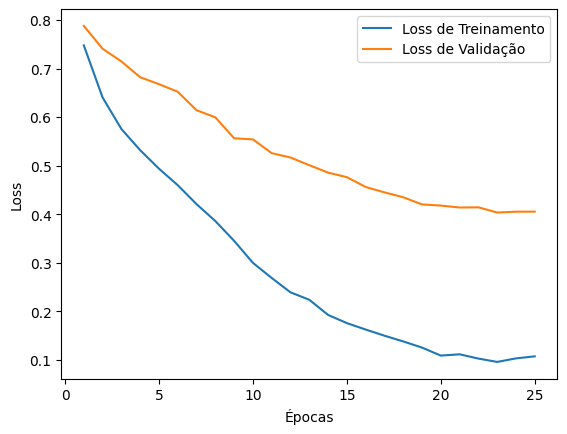

Modelo treinado!

Métricas de avaliação para DiceLoss:
	Mean Dice Coefficient: 0.7579
	Mean Jaccard Index: 0.6689
	Mean Hausdorff Distance: 4.1359
	Mean Average Surface Distance: 6.9096
	Processing Time (s): 0.0163
Treinando modelo com FocalLoss...
Época 1/25 / Loss: 0.1156 / Val Loss: 0.1092
Época 2/25 / Loss: 0.0527 / Val Loss: 0.0675
Época 3/25 / Loss: 0.0340 / Val Loss: 0.0636
Época 4/25 / Loss: 0.0269 / Val Loss: 0.0564
Época 5/25 / Loss: 0.0220 / Val Loss: 0.0552
Época 6/25 / Loss: 0.0177 / Val Loss: 0.0677
Época 7/25 / Loss: 0.0154 / Val Loss: 0.0502
Época 8/25 / Loss: 0.0155 / Val Loss: 0.0510
Época 9/25 / Loss: 0.0134 / Val Loss: 0.0528
Época 10/25 / Loss: 0.0111 / Val Loss: 0.0515
Época 11/25 / Loss: 0.0100 / Val Loss: 0.0552
Época 12/25 / Loss: 0.0095 / Val Loss: 0.0567
Época 13/25 / Loss: 0.0089 / Val Loss: 0.0616
Época 14/25 / Loss: 0.0086 / Val Loss: 0.0579
Época 15/25 / Loss: 0.0080 / Val Loss: 0.0546
Época 16/25 / Loss: 0.0078 / Val Loss: 0.0626
Época 17/25 / Loss: 0.00

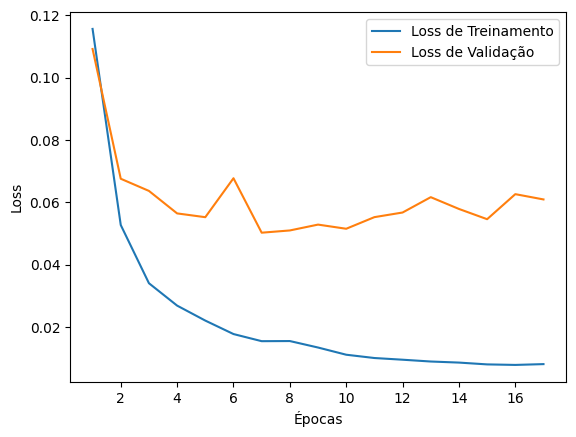

Modelo treinado!

Métricas de avaliação para FocalLoss:
	Mean Dice Coefficient: 0.7472
	Mean Jaccard Index: 0.6509
	Mean Hausdorff Distance: 4.1742
	Mean Average Surface Distance: 8.9828
	Processing Time (s): 0.0146
Treinando modelo com LovaszLoss...
Época 1/25 / Loss: 1.4125 / Val Loss: 1.3792
Época 2/25 / Loss: 0.9759 / Val Loss: 1.1661
Época 3/25 / Loss: 0.7963 / Val Loss: 1.1234
Época 4/25 / Loss: 0.6056 / Val Loss: 1.1771
Época 5/25 / Loss: 0.4620 / Val Loss: 1.2171
Época 6/25 / Loss: 0.4191 / Val Loss: 1.1613
Época 7/25 / Loss: 0.3874 / Val Loss: 1.1336
Época 8/25 / Loss: 0.3628 / Val Loss: 1.1545
Época 9/25 / Loss: 0.3185 / Val Loss: 1.1521
Época 10/25 / Loss: 0.3120 / Val Loss: 1.1670
Época 11/25 / Loss: 0.2705 / Val Loss: 1.1449
Época 12/25 / Loss: 0.2434 / Val Loss: 1.2115
Época 13/25 / Loss: 0.2321 / Val Loss: 1.1452
Early stopping após 13 épocas.


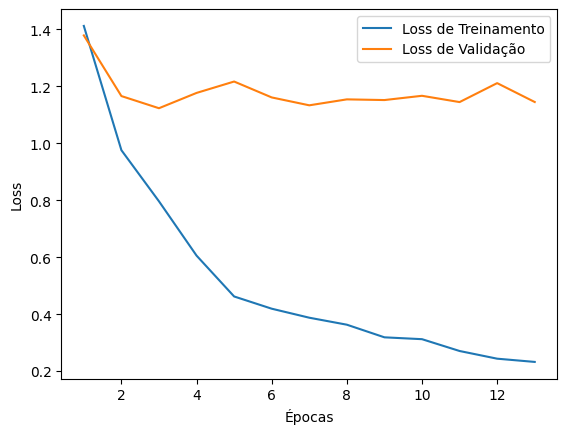

Modelo treinado!

Métricas de avaliação para LovaszLoss:
	Mean Dice Coefficient: 0.7488
	Mean Jaccard Index: 0.6562
	Mean Hausdorff Distance: 4.7856
	Mean Average Surface Distance: 9.7482
	Processing Time (s): 0.0151


In [17]:
preprocess_input = get_preprocessing_fn('xception', pretrained='imagenet')

# Definição das funções de perda
loss_functions = {
    "DiceLoss": smp.losses.DiceLoss(smp.losses.BINARY_MODE),
    "FocalLoss": smp.losses.FocalLoss(mode=smp.losses.BINARY_MODE),
    "LovaszLoss": smp.losses.LovaszLoss(smp.losses.BINARY_MODE)
}

for loss_name, loss_fn in loss_functions.items():
    print(f"Treinando modelo com {loss_name}...")
    
    # Inicializa o modelo
    model = smp.Unet(
        encoder_name="xception",
        encoder_weights="imagenet",
        in_channels=1,
        classes=1,
    ).to(DEVICE)
    
    # Inicializa o otimizador
    optimizer = optim.Adam(model.parameters(), lr=1e-4)
    
    # Define o caminho para salvar o modelo
    model_path = os.path.join(MODELS_PATH, f"xception_unet_{loss_name.lower()}_model.pth")
    
    if os.path.exists(model_path):
        model.load_state_dict(torch.load(model_path))
        print("Modelo carregado!")
    else:
        # Define os data loaders
        train_loader = DataLoader(
            train_dataset,
            batch_size=BATCH_SIZE,
            pin_memory=True,
            shuffle=True,
            drop_last=False,
            num_workers=N_WORKERS
        )
    
        val_loader = DataLoader(
            val_dataset,
            batch_size=BATCH_SIZE,
            pin_memory=True,
            shuffle=False,
            drop_last=False,
            num_workers=N_WORKERS
        )
        
        # Treina o modelo
        train(model, train_loader, val_loader, loss_fn, optimizer, 25)
        
        # Salva o modelo treinado
        save_model(model, model_path)
        print("Modelo treinado!")
    
    # Carrega o data loader de teste
    test_loader = DataLoader(
        test_dataset,
        batch_size=BATCH_SIZE,
        pin_memory=True,
        shuffle=False,
        drop_last=False,
        num_workers=N_WORKERS
    )
    
    # Avalia o modelo
    metrics = evaluate(model, test_loader)
    print(f"\nMétricas de avaliação para {loss_name}:")
    for metric, value in metrics.items():
        print(f"\t{metric}: {value:.4f}")


# Encoder: VGG19 / Decoder: UNET

Treinando modelo com DiceLoss...
Época 1/25 / Loss: 0.7617 / Val Loss: 0.7775
Época 2/25 / Loss: 0.6805 / Val Loss: 0.7519
Época 3/25 / Loss: 0.6560 / Val Loss: 0.7422
Época 4/25 / Loss: 0.6332 / Val Loss: 0.7373
Época 5/25 / Loss: 0.6067 / Val Loss: 0.7261
Época 6/25 / Loss: 0.6006 / Val Loss: 0.7234
Época 7/25 / Loss: 0.5793 / Val Loss: 0.7284
Época 8/25 / Loss: 0.5660 / Val Loss: 0.7100
Época 9/25 / Loss: 0.5485 / Val Loss: 0.7055
Época 10/25 / Loss: 0.5204 / Val Loss: 0.6833
Época 11/25 / Loss: 0.5021 / Val Loss: 0.6548
Época 12/25 / Loss: 0.4797 / Val Loss: 0.6794
Época 13/25 / Loss: 0.4442 / Val Loss: 0.6491
Época 14/25 / Loss: 0.4260 / Val Loss: 0.6151
Época 15/25 / Loss: 0.3964 / Val Loss: 0.6289
Época 16/25 / Loss: 0.3794 / Val Loss: 0.6175
Época 17/25 / Loss: 0.3623 / Val Loss: 0.5723
Época 18/25 / Loss: 0.3303 / Val Loss: 0.5773
Época 19/25 / Loss: 0.3078 / Val Loss: 0.5727
Época 20/25 / Loss: 0.2923 / Val Loss: 0.5565
Época 21/25 / Loss: 0.2690 / Val Loss: 0.5511
Época 22/2

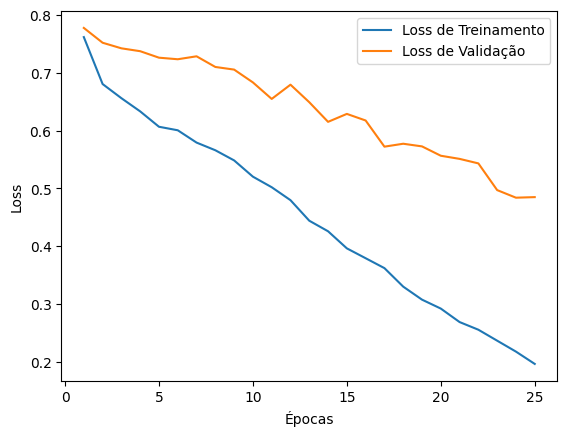

Modelo treinado!

Métricas de avaliação para DiceLoss:
	Mean Dice Coefficient: 0.7842
	Mean Jaccard Index: 0.6969
	Mean Hausdorff Distance: 3.9528
	Mean Average Surface Distance: 7.7577
	Processing Time (s): 0.0104
Treinando modelo com FocalLoss...
Época 1/25 / Loss: 0.1887 / Val Loss: 0.1189
Época 2/25 / Loss: 0.0891 / Val Loss: 0.0851
Época 3/25 / Loss: 0.0628 / Val Loss: 0.0594
Época 4/25 / Loss: 0.0476 / Val Loss: 0.0551
Época 5/25 / Loss: 0.0369 / Val Loss: 0.0514
Época 6/25 / Loss: 0.0314 / Val Loss: 0.0472
Época 7/25 / Loss: 0.0264 / Val Loss: 0.0453
Época 8/25 / Loss: 0.0238 / Val Loss: 0.0508
Época 9/25 / Loss: 0.0215 / Val Loss: 0.0495
Época 10/25 / Loss: 0.0191 / Val Loss: 0.0599
Época 11/25 / Loss: 0.0173 / Val Loss: 0.0440
Época 12/25 / Loss: 0.0167 / Val Loss: 0.0617
Época 13/25 / Loss: 0.0154 / Val Loss: 0.0758
Época 14/25 / Loss: 0.0146 / Val Loss: 0.0656
Época 15/25 / Loss: 0.0129 / Val Loss: 0.0549
Época 16/25 / Loss: 0.0121 / Val Loss: 0.0829
Época 17/25 / Loss: 0.01

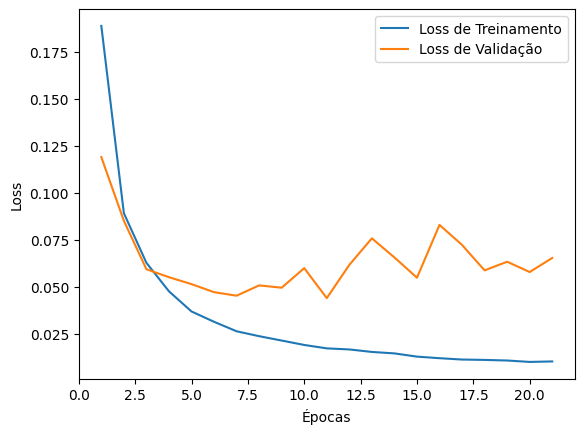

Modelo treinado!

Métricas de avaliação para FocalLoss:
	Mean Dice Coefficient: 0.7499
	Mean Jaccard Index: 0.6642
	Mean Hausdorff Distance: 4.3275
	Mean Average Surface Distance: 10.3555
	Processing Time (s): 0.0071
Treinando modelo com LovaszLoss...
Época 1/25 / Loss: 1.8770 / Val Loss: 1.3937
Época 2/25 / Loss: 1.2175 / Val Loss: 1.1473
Época 3/25 / Loss: 1.1479 / Val Loss: 1.1056
Época 4/25 / Loss: 1.0609 / Val Loss: 1.0488
Época 5/25 / Loss: 1.0508 / Val Loss: 1.0421
Época 6/25 / Loss: 1.0250 / Val Loss: 1.0283
Época 7/25 / Loss: 1.0385 / Val Loss: 1.0208
Época 8/25 / Loss: 1.0073 / Val Loss: 1.0085
Época 9/25 / Loss: 1.0101 / Val Loss: 1.0060
Época 10/25 / Loss: 1.0122 / Val Loss: 1.0058
Época 11/25 / Loss: 1.0054 / Val Loss: 1.0083
Época 12/25 / Loss: 1.0034 / Val Loss: 1.0044
Época 13/25 / Loss: 1.0031 / Val Loss: 1.0026
Época 14/25 / Loss: 1.0092 / Val Loss: 1.0038
Época 15/25 / Loss: 1.0043 / Val Loss: 1.0032
Época 16/25 / Loss: 1.0122 / Val Loss: 1.0169
Época 17/25 / Loss: 1

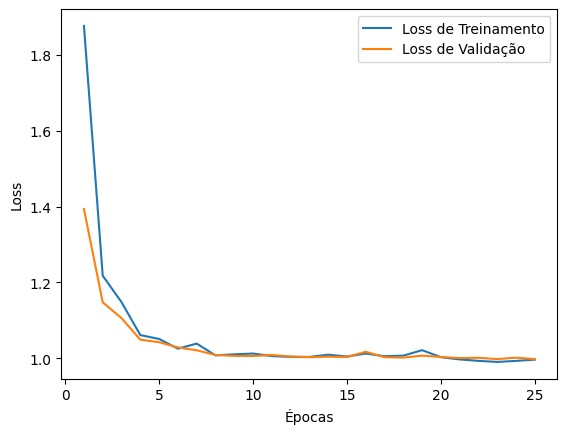

Modelo treinado!

Métricas de avaliação para LovaszLoss:
	Mean Dice Coefficient: 0.4769
	Mean Jaccard Index: 0.3502
	Mean Hausdorff Distance: 7.6910
	Mean Average Surface Distance: 31.3139
	Processing Time (s): 0.0064


In [18]:
preprocess_input = get_preprocessing_fn('vgg19', pretrained='imagenet')

# Definição das funções de perda
loss_functions = {
    "DiceLoss": smp.losses.DiceLoss(smp.losses.BINARY_MODE),
    "FocalLoss": smp.losses.FocalLoss(mode=smp.losses.BINARY_MODE),
    "LovaszLoss": smp.losses.LovaszLoss(smp.losses.BINARY_MODE)
}

for loss_name, loss_fn in loss_functions.items():
    print(f"Treinando modelo com {loss_name}...")
    
    # Inicializa o modelo
    model = smp.Unet(
        encoder_name="vgg19",
        encoder_weights="imagenet",
        in_channels=1,
        classes=1,
    ).to(DEVICE)
    
    # Inicializa o otimizador
    optimizer = optim.Adam(model.parameters(), lr=1e-4)
    
    # Define o caminho para salvar o modelo
    model_path = os.path.join(MODELS_PATH, f"vgg19_unet_{loss_name.lower()}_model.pth")
    
    if os.path.exists(model_path):
        model.load_state_dict(torch.load(model_path))
        print("Modelo carregado!")
    else:
        # Define os data loaders
        train_loader = DataLoader(
            train_dataset,
            batch_size=BATCH_SIZE,
            pin_memory=True,
            shuffle=True,
            drop_last=False,
            num_workers=N_WORKERS
        )
    
        val_loader = DataLoader(
            val_dataset,
            batch_size=BATCH_SIZE,
            pin_memory=True,
            shuffle=False,
            drop_last=False,
            num_workers=N_WORKERS
        )
        
        # Treina o modelo
        train(model, train_loader, val_loader, loss_fn, optimizer, 25)
        
        # Salva o modelo treinado
        save_model(model, model_path)
        print("Modelo treinado!")
    
    # Carrega o data loader de teste
    test_loader = DataLoader(
        test_dataset,
        batch_size=BATCH_SIZE,
        pin_memory=True,
        shuffle=False,
        drop_last=False,
        num_workers=N_WORKERS
    )
    
    # Avalia o modelo
    metrics = evaluate(model, test_loader)
    print(f"\nMétricas de avaliação para {loss_name}:")
    for metric, value in metrics.items():
        print(f"\t{metric}: {value:.4f}")


# Encoder: InceptionV4 / Decoder: UNET

Treinando modelo com DiceLoss...


Downloading: "http://data.lip6.fr/cadene/pretrainedmodels/inceptionv4-8e4777a0.pth" to /home/tivo/.cache/torch/hub/checkpoints/inceptionv4-8e4777a0.pth
100%|██████████| 163M/163M [08:00<00:00, 356kB/s] 


Época 1/25 / Loss: 0.7653 / Val Loss: 0.8145
Época 2/25 / Loss: 0.6930 / Val Loss: 0.7931
Época 3/25 / Loss: 0.6445 / Val Loss: 0.7637
Época 4/25 / Loss: 0.6093 / Val Loss: 0.7438
Época 5/25 / Loss: 0.5651 / Val Loss: 0.7208
Época 6/25 / Loss: 0.5360 / Val Loss: 0.6961
Época 7/25 / Loss: 0.4998 / Val Loss: 0.6856
Época 8/25 / Loss: 0.4629 / Val Loss: 0.6582
Época 9/25 / Loss: 0.4131 / Val Loss: 0.6446
Época 10/25 / Loss: 0.3937 / Val Loss: 0.6301
Época 11/25 / Loss: 0.3507 / Val Loss: 0.5998
Época 12/25 / Loss: 0.3141 / Val Loss: 0.5678
Época 13/25 / Loss: 0.2985 / Val Loss: 0.5552
Época 14/25 / Loss: 0.2643 / Val Loss: 0.5281
Época 15/25 / Loss: 0.2479 / Val Loss: 0.5048
Época 16/25 / Loss: 0.2192 / Val Loss: 0.5237
Época 17/25 / Loss: 0.1862 / Val Loss: 0.4783
Época 18/25 / Loss: 0.1753 / Val Loss: 0.4816
Época 19/25 / Loss: 0.1544 / Val Loss: 0.4626
Época 20/25 / Loss: 0.1437 / Val Loss: 0.4510
Época 21/25 / Loss: 0.1346 / Val Loss: 0.4426
Época 22/25 / Loss: 0.1277 / Val Loss: 0.44

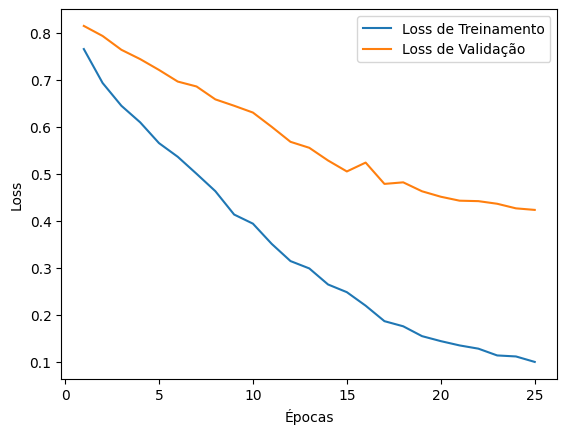

Modelo treinado!

Métricas de avaliação para DiceLoss:
	Mean Dice Coefficient: 0.7509
	Mean Jaccard Index: 0.6545
	Mean Hausdorff Distance: 4.2169
	Mean Average Surface Distance: 7.6374
	Processing Time (s): 0.0400
Treinando modelo com FocalLoss...
Época 1/25 / Loss: 0.1411 / Val Loss: 0.1816
Época 2/25 / Loss: 0.0742 / Val Loss: 0.0936
Época 3/25 / Loss: 0.0485 / Val Loss: 0.0918
Época 4/25 / Loss: 0.0341 / Val Loss: 0.4173
Época 5/25 / Loss: 0.0278 / Val Loss: 0.1394
Época 6/25 / Loss: 0.0238 / Val Loss: 0.1290
Época 7/25 / Loss: 0.0218 / Val Loss: 0.1969
Época 8/25 / Loss: 0.0210 / Val Loss: 0.0408
Época 9/25 / Loss: 0.0184 / Val Loss: 0.0453
Época 10/25 / Loss: 0.0159 / Val Loss: 0.0490
Época 11/25 / Loss: 0.0141 / Val Loss: 0.0483
Época 12/25 / Loss: 0.0122 / Val Loss: 0.0475
Época 13/25 / Loss: 0.0113 / Val Loss: 0.0473
Época 14/25 / Loss: 0.0105 / Val Loss: 0.0484
Época 15/25 / Loss: 0.0099 / Val Loss: 0.0486
Época 16/25 / Loss: 0.0092 / Val Loss: 0.0531
Época 17/25 / Loss: 0.00

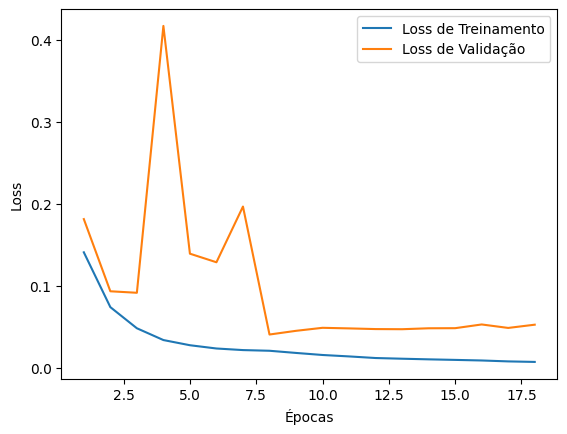

Modelo treinado!

Métricas de avaliação para FocalLoss:
	Mean Dice Coefficient: 0.7460
	Mean Jaccard Index: 0.6499
	Mean Hausdorff Distance: 4.3212
	Mean Average Surface Distance: 9.4064
	Processing Time (s): 0.0384
Treinando modelo com LovaszLoss...
Época 1/25 / Loss: 1.5671 / Val Loss: 1.5894
Época 2/25 / Loss: 1.0615 / Val Loss: 1.5243
Época 3/25 / Loss: 0.9352 / Val Loss: 1.1267
Época 4/25 / Loss: 0.7926 / Val Loss: 1.1780
Época 5/25 / Loss: 0.6394 / Val Loss: 1.1445
Época 6/25 / Loss: 0.4821 / Val Loss: 1.1818
Época 7/25 / Loss: 0.5009 / Val Loss: 1.0797
Época 8/25 / Loss: 0.4208 / Val Loss: 1.1503
Época 9/25 / Loss: 0.3894 / Val Loss: 1.0977
Época 10/25 / Loss: 0.3250 / Val Loss: 1.0936
Época 11/25 / Loss: 0.3008 / Val Loss: 1.0899
Época 12/25 / Loss: 0.3003 / Val Loss: 1.0841
Época 13/25 / Loss: 0.2914 / Val Loss: 1.0891
Época 14/25 / Loss: 0.2826 / Val Loss: 1.1270
Época 15/25 / Loss: 0.2615 / Val Loss: 1.1865
Época 16/25 / Loss: 0.2353 / Val Loss: 1.1265
Época 17/25 / Loss: 0.

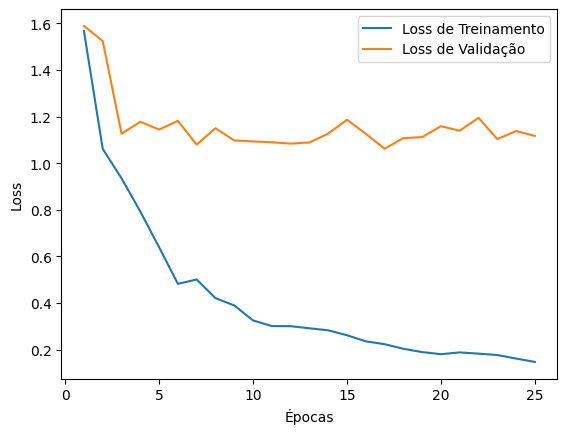

Modelo treinado!

Métricas de avaliação para LovaszLoss:
	Mean Dice Coefficient: 0.7716
	Mean Jaccard Index: 0.6857
	Mean Hausdorff Distance: 4.6261
	Mean Average Surface Distance: 6.9455
	Processing Time (s): 0.0366


In [19]:
preprocess_input = get_preprocessing_fn('inceptionv4', pretrained='imagenet+background')

# Definição das funções de perda
loss_functions = {
    "DiceLoss": smp.losses.DiceLoss(smp.losses.BINARY_MODE),
    "FocalLoss": smp.losses.FocalLoss(mode=smp.losses.BINARY_MODE),
    "LovaszLoss": smp.losses.LovaszLoss(smp.losses.BINARY_MODE)
}

for loss_name, loss_fn in loss_functions.items():
    print(f"Treinando modelo com {loss_name}...")
    
    # Inicializa o modelo
    model = smp.Unet(
        encoder_name="inceptionv4",
        encoder_weights="imagenet+background",
        in_channels=1,
        classes=1,
    ).to(DEVICE)
    
    # Inicializa o otimizador
    optimizer = optim.Adam(model.parameters(), lr=1e-4)
    
    # Define o caminho para salvar o modelo
    model_path = os.path.join(MODELS_PATH, f"inceptionv4_unet_{loss_name.lower()}_model.pth")
    
    if os.path.exists(model_path):
        model.load_state_dict(torch.load(model_path))
        print("Modelo carregado!")
    else:
        # Define os data loaders
        train_loader = DataLoader(
            train_dataset,
            batch_size=BATCH_SIZE,
            pin_memory=True,
            shuffle=True,
            drop_last=False,
            num_workers=N_WORKERS
        )
    
        val_loader = DataLoader(
            val_dataset,
            batch_size=BATCH_SIZE,
            pin_memory=True,
            shuffle=False,
            drop_last=False,
            num_workers=N_WORKERS
        )
        
        # Treina o modelo
        train(model, train_loader, val_loader, loss_fn, optimizer, 25)
        
        # Salva o modelo treinado
        save_model(model, model_path)
        print("Modelo treinado!")
    
    # Carrega o data loader de teste
    test_loader = DataLoader(
        test_dataset,
        batch_size=BATCH_SIZE,
        pin_memory=True,
        shuffle=False,
        drop_last=False,
        num_workers=N_WORKERS
    )
    
    # Avalia o modelo
    metrics = evaluate(model, test_loader)
    print(f"\nMétricas de avaliação para {loss_name}:")
    for metric, value in metrics.items():
        print(f"\t{metric}: {value:.4f}")
